In [1]:
from sklearn.neighbors import NearestNeighbors
import os
import pickle
import numpy as np

from lib import get_data, get_features, get_nns, plot

Set-up fast nearest neighbour search

In [2]:
nn_model_name = "nn_model.pkl"
features_file = "dr16_features.npz"
ids_file = "dr16_ids.npz"

In [3]:
features = np.load(features_file)['arr_0']
ids = np.load(ids_file)['arr_0']

In [4]:
dataset, loader = get_data()

neigh = NearestNeighbors(n_neighbors=16)
neigh.fit(features)

Give the ra & dec of the desired query to the get_query() function to obtain its feature representation and show the results

16
Nearest neighbours:


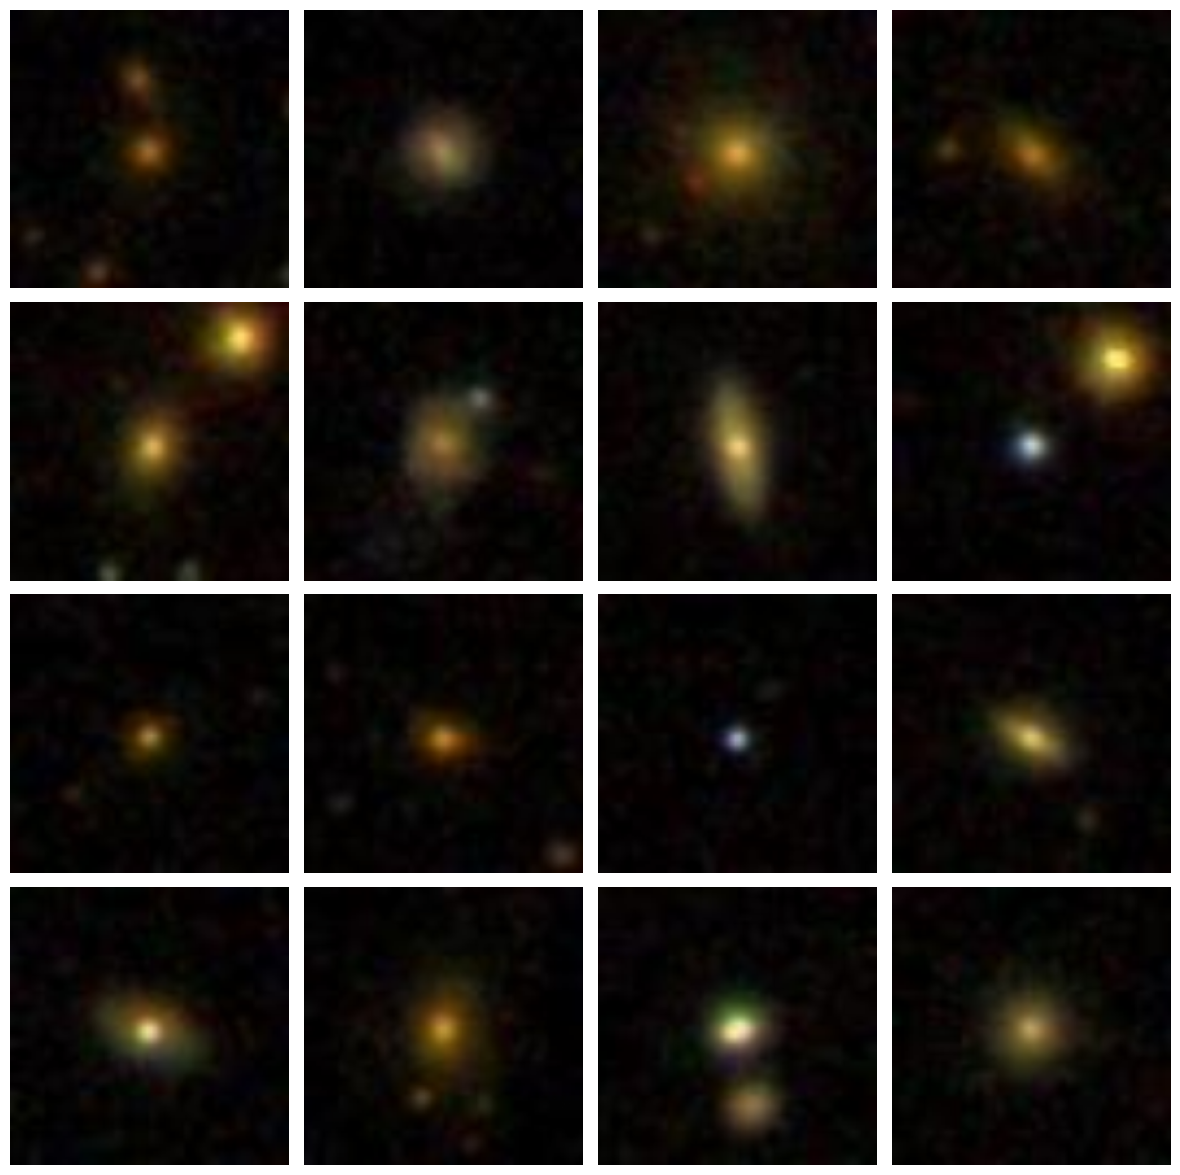

In [6]:
n_neighbors= 16

obj_id = 1000927260884101120

idx = np.where(ids == obj_id)[0][0]
query_features = features[idx].reshape(1, -1)

similar, dists = get_nns(query_features, neigh, n_neighbors)
print(len(similar))
plot(similar, dataset)